In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

import wandb
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from efficient_kan import KAN

In [2]:
L.seed_everything(125)

Seed set to 125


125

## Load Noisy Data

In [3]:
df = pd.read_parquet("./data.parquet")
df

,x,y
0,0.0000,20.239212
1,0.1001,19.173246
2,0.2002,19.736660
3,0.3003,19.289800
4,0.4004,19.614940
...,...,...
995,99.5996,13.279275
996,99.6997,14.038843
997,99.7998,13.098245
998,99.8999,13.125170


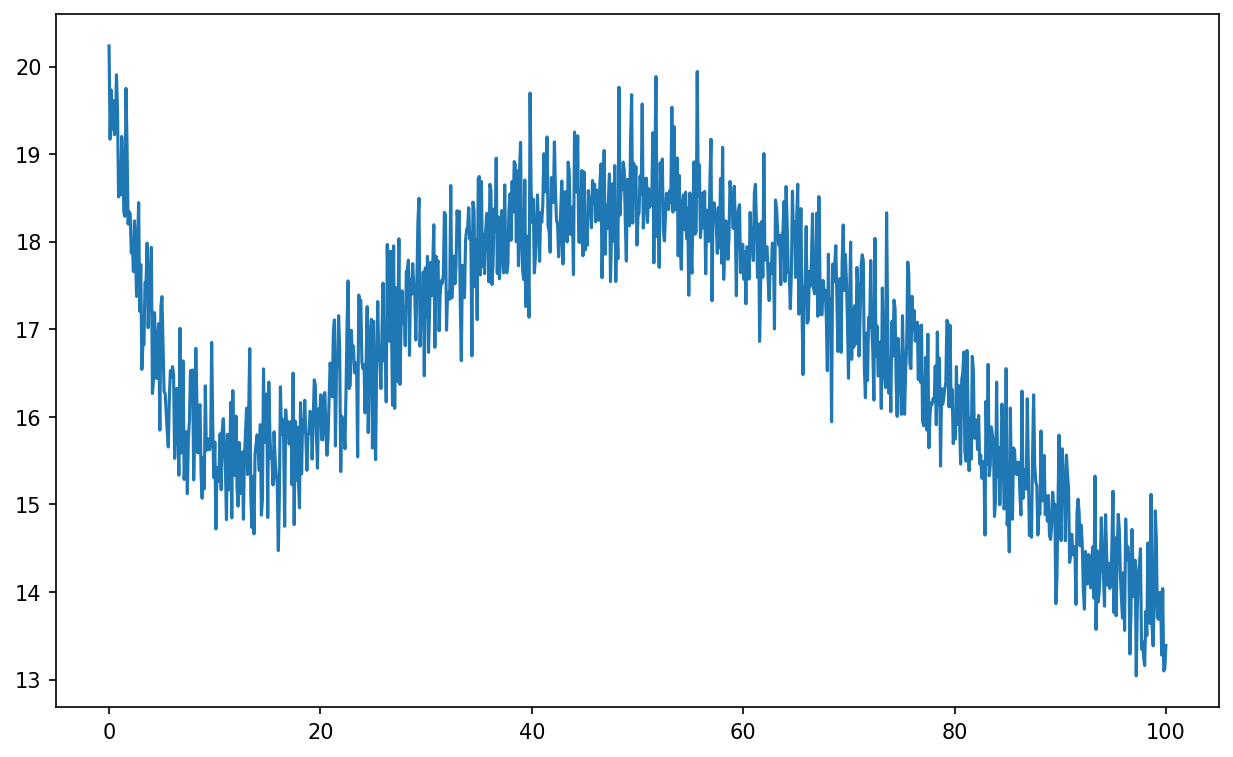

In [4]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(df['x'], df['y'])
plt.show()

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

print(df_train.shape)
print(df_test.shape)

(800, 2)
(200, 2)


In [6]:
df_train = df_train.sort_values(by=['x'])
df_test  = df_test.sort_values(by=['x'])

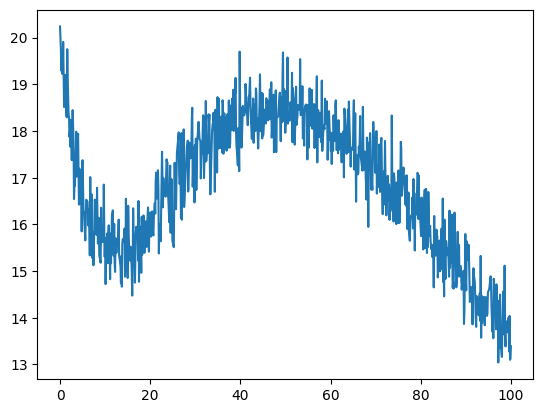

In [7]:
plt.plot(df_train['x'], df_train['y'])
plt.show()

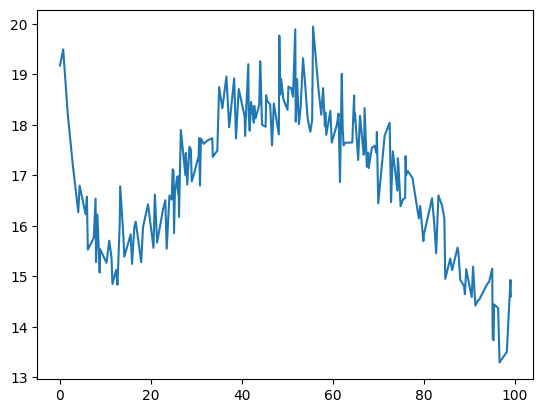

In [8]:
plt.plot(df_test['x'], df_test['y'])
plt.show()

In [9]:
scaler = RobustScaler()

scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test  = scaler.transform(df_test)

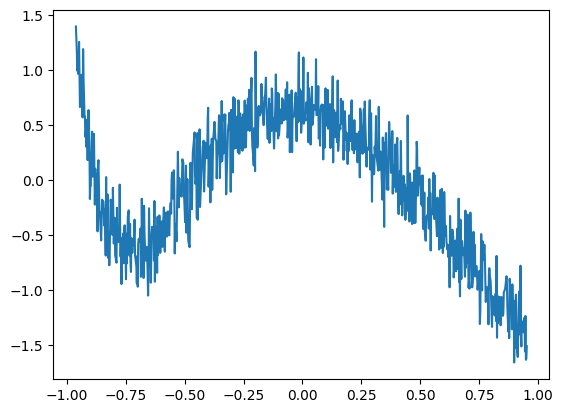

In [10]:
plt.plot(df_train[:,0], df_train[:,1])
plt.show()

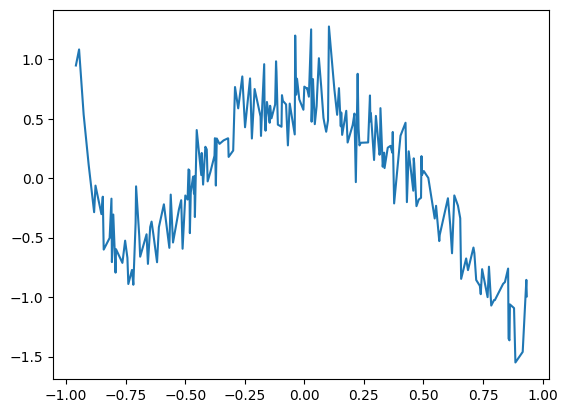

In [11]:
plt.plot(df_test[:,0], df_test[:,1])
plt.show()

In [12]:
class NoisyData(Dataset):
    def __init__(self, df):
        x = df[:,0]
        y = df[:,1]
        self.x = torch.tensor(x, dtype=torch.float32).reshape((-1,1))
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [13]:
ds_train = NoisyData(df_train)
ds_test  = NoisyData(df_test)

In [14]:
ds_train[:10]

(tensor([[-0.9608],
         [-0.9569],
         [-0.9550],
         [-0.9531],
         [-0.9512],
         [-0.9493],
         [-0.9474],
         [-0.9435],
         [-0.9416],
         [-0.9397]]),
 tensor([[1.4001],
         [1.1868],
         [0.9971],
         [1.1351],
         [0.9692],
         [0.9821],
         [1.2597],
         [0.6673],
         [0.8319],
         [0.6777]]))

## KAN

In [15]:
class KANREG(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.lr          = hparams['learning_rate']
        self.batch       = hparams['batch_size']
        self.hidden_size = hparams['hidden_size']
        self.epochs      = hparams['epochs']

        self.save_hyperparameters()

        self.net = KAN([1, self.hidden_size, 1])
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": OneCycleLR(
            #         optimizer,
            #         max_lr = self.lr,
            #         epochs = self.epochs,
            #         steps_per_epoch = len(ds_train) // self.batch + 1,
            #     ),
            #     "interval": "step",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
            "lr_scheduler": {
                "scheduler": PolynomialLR(
                    optimizer,
                    total_iters = self.epochs,
                    power = 2.0
                ),
                "interval": "epoch",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [16]:
hparams = {
    'learning_rate': 1e-2,
    'batch_size': 32,
    'epochs': 500,
    'hidden_size': 5,
}

In [17]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
dl_test  = DataLoader(ds_test, batch_size=hparams['batch_size'], shuffle=False)

In [18]:
model = KANREG(hparams)
model

KANREG(
  (net): KAN(
    (layers): ModuleList(
      (0-1): 2 x KANLinear(
        (base_activation): SiLU()
      )
    )
  )
  (loss_fn): MSELoss()
)

In [19]:
model(ds_train[:10][0]);

In [20]:
wandb_logger = WandbLogger(
    project="Noisy_Regression"  
)

In [21]:
trainer = Trainer(
    logger = wandb_logger,
    max_epochs = hparams['epochs'],
    devices=[0],
    accelerator='auto',
    enable_progress_bar=False,
    callbacks=[
        ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=3),
        LearningRateMonitor(logging_interval="epoch"),
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, dl_train, dl_test)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 4GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | net     | KAN     | 100   
1 | loss_fn | MSELoss | 0     
------------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)
/home/xteca/Documents/Project/Machine_Learning/Noisy_Regression/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/xteca/Documents/Project/Machine_Learning/Noisy_Regression/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

In [23]:
import os, re

In [24]:
ckpt_dir = f"./Noisy_Regression/{wandb.run.id}/checkpoints/"
regex    = re.compile('epoch=(\d+)-step=(\d+).ckpt')
candis   = []
for root, _, files in os.walk(ckpt_dir):
    for file in files:
        if regex.match(file):
            candis.append(root + file)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_27007/2252277119.py:2: SyntaxWarning: invalid escape sequence '\d'
  regex    = re.compile('epoch=(\d+)-step=(\d+).ckpt')


In [25]:
candis

['./Noisy_Regression/32ao7sli/checkpoints/epoch=77-step=1950.ckpt',
 './Noisy_Regression/32ao7sli/checkpoints/epoch=113-step=2850.ckpt',
 './Noisy_Regression/32ao7sli/checkpoints/epoch=117-step=2950.ckpt']

In [27]:
best_model = KANREG.load_from_checkpoint(candis[-1])
best_model

KANREG(
  (net): KAN(
    (layers): ModuleList(
      (0-1): 2 x KANLinear(
        (base_activation): SiLU()
      )
    )
  )
  (loss_fn): MSELoss()
)

In [28]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▅▃▅▄▄▃▄▃▅▄▅▅▃▄▃▄▁▂▃▃▁▃▂▄▄▄▃▅▃▂▄▂▅▁▂▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▄▂▁▃▂▂▁▂▃▁▂▁▂▂▁▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,499
lr-Adam,0.0
train_loss,0.05102
trainer/global_step,12499
val_loss,0.0453


In [29]:
def decoder(model, dl):
    x_input = []
    y_input = []
    y_output = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        y_hat = model(x)
        y_output.extend(y_hat.detach().cpu().numpy().flatten())

    return x_input, y_input, y_output

In [30]:
x_input, y_input, y_output = decoder(model, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

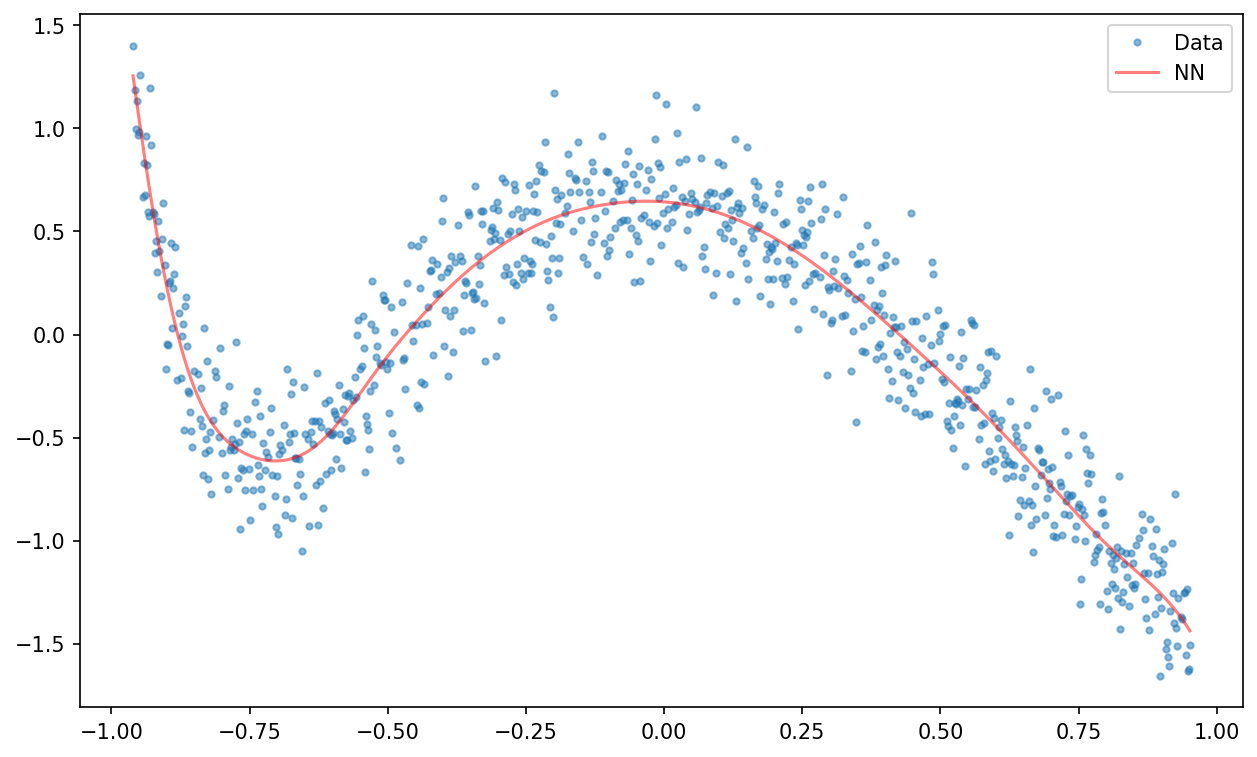

In [31]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()

In [32]:
x_input, y_input, y_output = decoder(model, dl_test)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

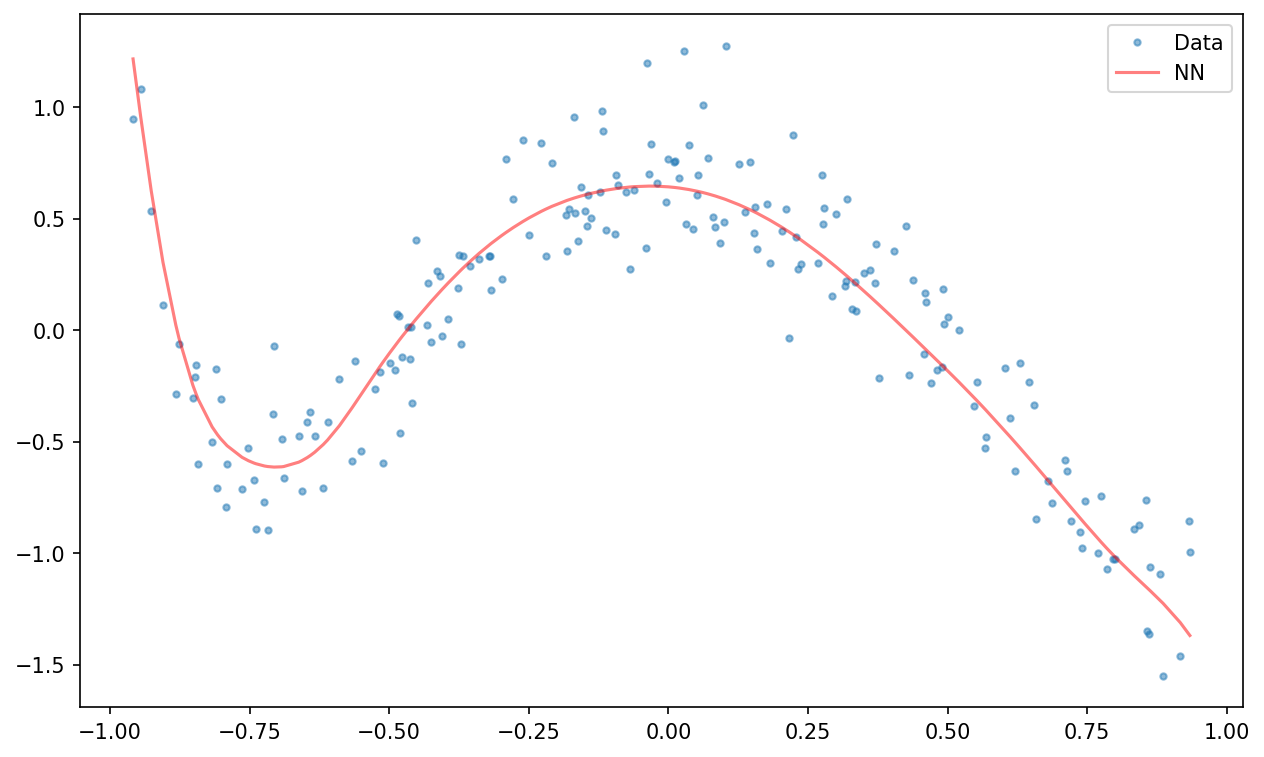

In [33]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()

In [36]:
x_test = torch.linspace(-1.1, 1.1, 100).reshape((-1,1))
y_test = model(x_test.to(model.device))

x_test = x_test.detach().cpu().numpy().flatten()
y_test = y_test.detach().cpu().numpy().flatten()

# xy_test = scaler.inverse_transform(np.column_stack([x_test, y_test]))
# x_test  = xy_test[:,0]
# y_test  = xy_test[:,1]
# std_test = std_test * scaler.scale_[1]

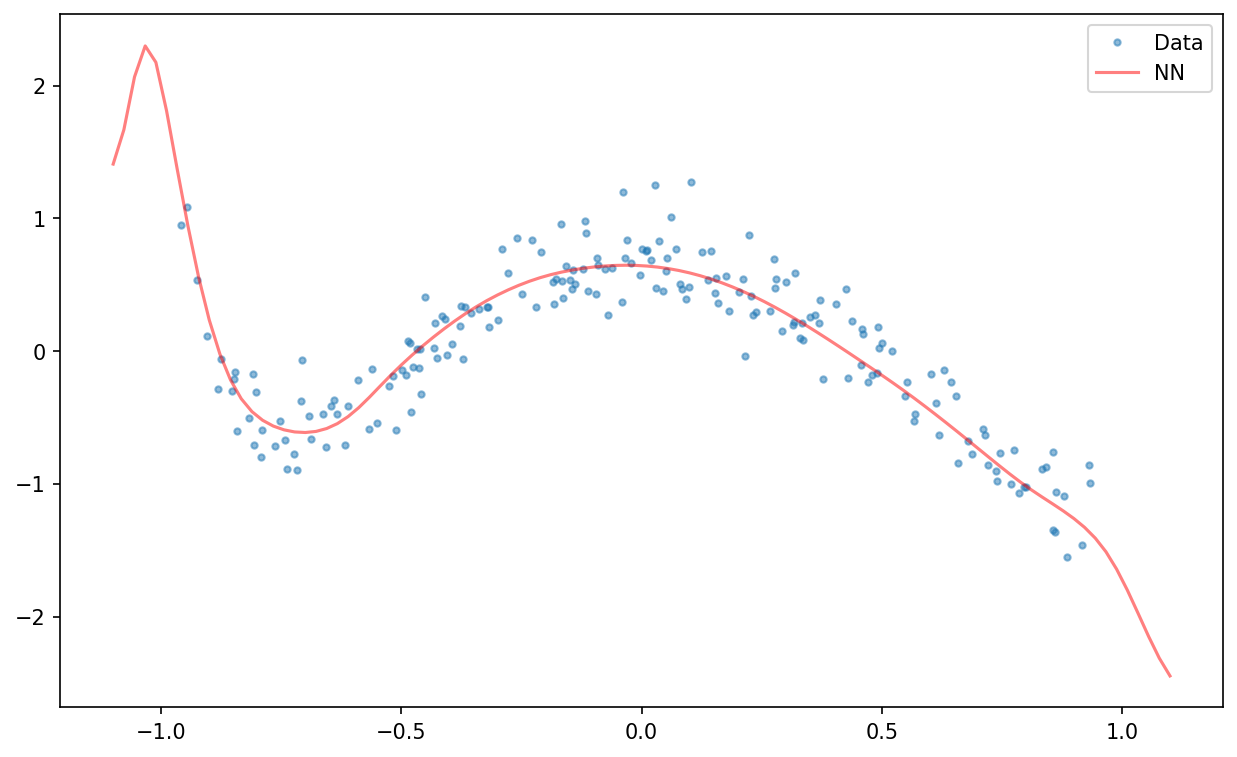

In [37]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(x_test, y_test, 'r-', label='NN', alpha=0.5)
# plt.fill_between(X_hat[:,0], X_hat[:,1] - X_hat[:,2], X_hat[:,1] + X_hat[:,2], color='r', alpha=0.2)
plt.legend()
plt.show()